## WebbPSF Multifield Model for OTE WFE

This page documents the model for the field dependence of the OTE WFE as implemented in WebbPSF.

Background: Wavefront error is in general somewhat different at each of the different points in the image field.  These wavefront errors are inherent in the design of the optical system, even when the system is aligned perfectly.  

As a result, one can think of the system's field-varying wavefront error, as being dependent on four coordinates,
$$\phi\left(x,y;,u,v\right),$$
where (x,y) are the lateral coordinate of the wavefront in the system's pupil plane and (u,v) are the lateral coordinates of the image point in the image plane.
From a numerical modeling perspective, it is challenging to represent this function of four continuous variables efficiently.  In most optical design and analysis programs (such as CodeV, Zemax, or Oslo) this is typically handled by computing the wavefront error as needed at a small number of carefully chosen pupil and field points.  However, in WebbPSF (and other diffraction computation tools) is is necessary to know the wavefront distribution across a sampled version of the entire pupil, $$\phi\left(x,y\right).$$  Most tools assume that the field variations are constant over the region of interest, typically a single field point.  Optical design software generally makes it straightforward to compute this wavefront and export the resulting two-dimensional sampled data at a particular field point.  It may also be desirable to express the wavefront in terms of the coefficients $\alpha_j$ of a set of two dimensional polynomials $Z_j\left(x,y\right)$, where the wavefront can be calculated as
$$\phi\left(x,y\right) = \sum\limits _j \alpha_jZ_j\left({x,y}\right).$$
The set of Zernike polynomials is a popular choice here.



<img src="zernikes.png" width="600">
<center>Figure 1: The first 21 Zernike polynomials, using the ordering and normalization of R.J. Noll, JOSA 66, 207-211 (1976).
</center>

When dealing with systems where there are significant field-dependent aberrations, particularly large-field systems like JWST, a single field assumption is often inadequate to represent the performance of the optical system.  The most direct approach to handling this is to compute the wavefront using an optical analysis program on-demand for each field point of interest.  This is a very computationally expensive approach.  An alternate approach is to store a large ensemble of wavefronts, discrete sampling various field points, and perform multidimensional interpolation to compute the wavefront at the desired field point.  This is storage intensive and somewhat computationally expensive.
A third approach, used here, is to use a polynomial expansion using Zernikes polynomials where the polynomial coefficients $\alpha_j\left(u,v\right)$ vary with field.  Thus the wavefront is computed using expression
$$\phi(x,y;u,v) = \sum\limits _j \alpha_j\left({u,v}\right)Z_j\left({x,y}\right)$$
The field varying characteristic of the polynomial coefficents is captured by performing a second polynomial expansion on each of the coefficients,
$$\alpha_j\left(u,v\right) = \sum\limits_k\beta_{j,k}L_k\left(u,v\right),$$
where $\beta_{j,k}$ is the coffiencient of this second expansion corresponding to the $j^{th}$ Zernike term and $L_k \left(u,v\right)$ is a set of polynomials that vary across field.  The $L_k \left(u,v\right)$ polynomials are typically straightforward to compute at an arbitrary field point.  While Zernike polynomials or other similar sets can be used here, we have elected to use a set of two-dimensional Legendre polynomials for this in WebbPSF since the instrument fields of interest are typically rectangular and the Legendres are orthonormal over a rectangular region.

<img src="Legendre.png" width="600">
<center>Figure 2: The first 21 Legendre polynomials.
</center>

Thus field dependence of the optical system of interest can be entirely characterized by a relatively small, two-dimensional  matrix of $\beta_{j,k}$ coefficients.
These coefficients have been precomputed for use in WebbPSF by using the most up-to-date CodeV models of the JWST optical telescope assembly (OTE).  For the highest fidelity, a set of these coefficients is computed separately for each of the instrument fields.

## Field Dependence in JWST
To build our field dependence model in WebbPSF, we have employed the as-built CodeV model of JWST derived from the nominal optical design for JWST, measurements of the figure of individual components, and end-to-end measurements of the OTE wavefront error conducted in the course of the JWST test campaign.  In the figure below we show the wavefront at a selection of field points, generally in the corners of the instrument fields.  The variation of wavefront with field angle is quite evident.


<img src="codev_field_dep_raw.png" width="1200">
<center>Figure 3: CodeV modeled wavefronts.  Note that the X and Y field angles in this figure are analagous to the $\left(u,v\right)$ coordinates in our above notation.
</center>

For practical use with WebbPSF, we are interested in the variation of the wavefront with field from the nominal wavefront defined in WebbPSF.  To facilitate these, we subtract the wavefront modeled by CodeV at its (0,0) field point.  In JWST $\left(v_2,v_3\right)$ field coordinates, this is at the location (0, -468 arcsec).  The following figure shows the field-dependent wavefronts at the same points as above but with the nominal wavefront subtracted and plotted in the $\left(v_2,v_3\right)$ coordinate system.  Residual piston, tip and tilt terms are also removed from the wavefront and are not modeled.

<img src="codev_field_dep_ptt_sub.png" width="1200">
<center>Figure 4: CodeV modeled wavefronts with nominal wavefront and piston, tip and tilt removed. JWST $\left(v_2,v_3\right)$ is the lateral coordinate system used here.
</center>

If we then use our polynomial-based WebbPSF model to calculate the wavefront variation at the same field points we have the following result.


<img src="webbpsf_field_dep.png" width="1200">

<center>Figure 5: WebbPSF modeled wavefronts with nominal wavefront and piston, tip and tilt removed. JWST $\left(v_2,v_3\right)$ is the lateral coordinate system used here.
</center>

## Model usage in WebbPSF

The model is implemented in the `_get_field_dependence_nominal_ote()` method of the `OTE_Linear_Model_WSS` class in the opds.py file of WebbPSF.  WebbPSF will apply the field-dependence model automatically when used in the ordinary way. The following illustrates the calculation of a PSF that uses the field-dependent model

First, do some setup

In [ ]:
%pylab inline
matplotlib.rcParams['image.origin'] = 'lower'
import webbpsf
import astropy.units as u
webbpsf.setup_logging()


Set up an instance of a WebbPSF NIRCam object with the F444W filter

In [2]:
nc = webbpsf.NIRCam()
nc.filter='F444W'
nc.detector = 'NRCA5'

[webbpsf] NIRCam aperture name updated to NRCA1_FULL
[webbpsf] NIRCam pixel scale switched to 0.063000 arcsec/pixel for the long wave channel.
[webbpsf] NIRCam aperture name updated to NRCA5_FULL


Now we call the calc_psf method.  This includes WebbPSF's data for the pupil wavefront and the apply the field-dependent perturbation calculated using our polynomial model.  Note the logging indicating that the field dependence has been applied.

In [3]:
psf = nc.calc_psf(nlambda=5, fov_arcsec=4, display=False)

[  poppy] No source spectrum supplied, therefore defaulting to 5700 K blackbody
[  poppy] Computing wavelength weights using synthetic photometry for F444W...
[  poppy] PSF calc using fov_arcsec = 4.000000, oversample = 4, number of wavelengths = 5
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: JWST+NIRCam
[  poppy] JWST Entrance Pupil: Loaded amplitude transmission from /Users/gbrady/Documents/Projects/WebbPSF/webbpsf-data/jwst_pupil_RevW_npix1024.fits.gz
[  poppy] JWST Entrance Pupil: Loaded OPD from /Users/gbrady/Documents/Projects/WebbPSF/webbpsf-data/NIRCam/OPD/OPD_RevW_ote_for_NIRCam_requirements.fits.gz
[webbpsf] Field coordinates determined to be in NIRCam field
[webbpsf] Loading field dependent model parameters from /Users/gbrady/Documents/Projects/WebbPSF/webbpsf-data/NIRCam/OPD/field_dep_table_nircam.fits
[webbpsf] Calculating field-dependent OPD at v2 = 1.435 arcmin, v3 = -8.224 arcmin
[  poppy] Added pupil plane: JWST Entrance Pupil
[  poppy]

Now we display the PSF

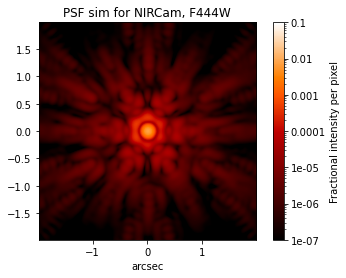

In [4]:
webbpsf.display_psf(psf)

We can display the pupil function used to compute this by getting the optical system object and using its visualization methods.

[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: JWST+NIRCam
[  poppy] JWST Entrance Pupil: Loaded amplitude transmission from /Users/gbrady/Documents/Projects/WebbPSF/webbpsf-data/jwst_pupil_RevW_npix1024.fits.gz
[  poppy] JWST Entrance Pupil: Loaded OPD from /Users/gbrady/Documents/Projects/WebbPSF/webbpsf-data/NIRCam/OPD/OPD_RevW_ote_for_NIRCam_requirements.fits.gz
[webbpsf] Field coordinates determined to be in NIRCam field
[webbpsf] Loading field dependent model parameters from /Users/gbrady/Documents/Projects/WebbPSF/webbpsf-data/NIRCam/OPD/field_dep_table_nircam.fits
[webbpsf] Calculating field-dependent OPD at v2 = 1.435 arcmin, v3 = -8.224 arcmin
[  poppy] Added pupil plane: JWST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] Added pupil plane: NIRCamLWA internal WFE at V2V3=(1.43,-8.22)', near MIMF5
[  poppy] Added detector with pixelscale=0.063 and oversampling=2: NIRCam detector


(<AxesSubplot:title={'center':'Transmittance for JWST Entrance Pupil'}, ylabel='[meters]'>,
 <AxesSubplot:title={'center':'OPD for JWST Entrance Pupil'}>)

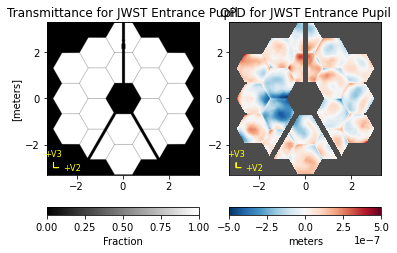

In [5]:
opt_sys = nc.get_optical_system()
opt_sys.planes[0].display(what='both')

We can also directly access the OPD perturbation using an instance of the OTE_Linear_Model_WSS class, which can take the field point v2,v3 as an argument.  This allows us to compute the OPD perturbation at an arbitrary field point.

[  poppy] Unnamed OPD: Loaded amplitude transmission from /Users/gbrady/Documents/Projects/WebbPSF/webbpsf-data/jwst_pupil_RevW_npix1024.fits.gz
[webbpsf] Field coordinates determined to be in NIRCam field
[webbpsf] Loading field dependent model parameters from /Users/gbrady/Documents/Projects/WebbPSF/webbpsf-data/NIRCam/OPD/field_dep_table_nircam.fits
[webbpsf] Calculating field-dependent OPD at v2 = 0.000 arcsec, v3 = -500.000 arcsec


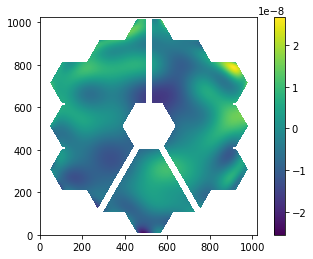

In [6]:
# Define field coordinate in angular units
v2 = 0 * u.arcsec
v3 = -500 * u.arcsec
# Instantiate OTE_Linear_Model_WSS
linmod = webbpsf.opds.OTE_Linear_Model_WSS(v2v3=(v2,v3))
# Get the OPD perturbation
plot_data = linmod.opd
# Get the pupil transmission
data_mask = linmod.get_transmission(0) != 0
# Set it up so we don't plot anything outside of the pupil
plot_data[~data_mask] = np.nan
# Do a simple plot of the data using imshow
plt.imshow(plot_data)
plt.colorbar()

We can use this same methodology to calculate the OPD distribution at a bunch of field points and plot them all on the same axis

WebbPSF log messages of level ERROR and above will be shown.
WebbPSF log outputs will be directed to the screen.


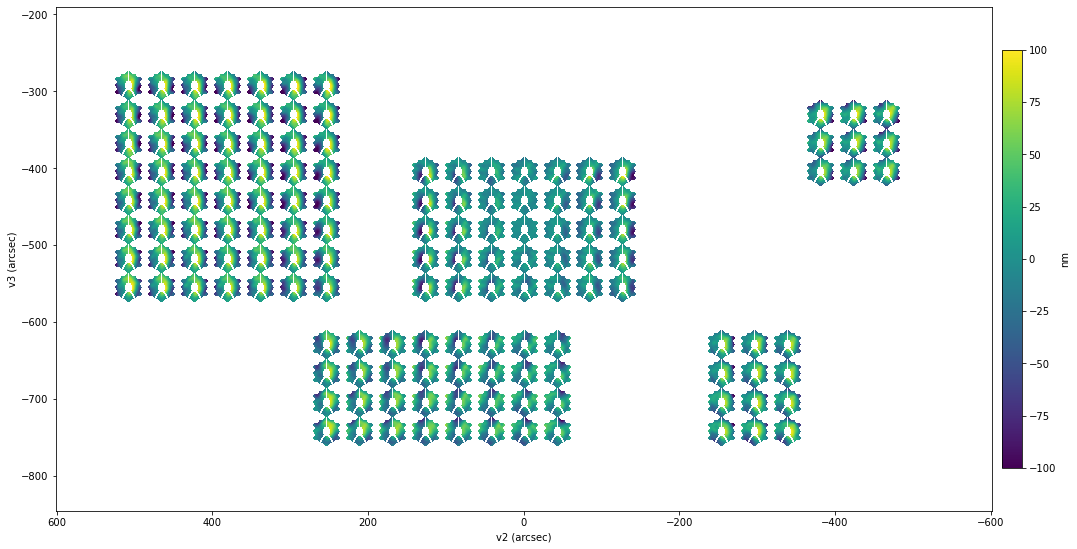

In [7]:
# Minimize logging output becuase it's a little overbearing here.
webbpsf.setup_logging(level='ERROR')

# Set up the limits of the very large field region over which we will calculate the OPD
min_v2field = 550 * u.arcsec
max_v2field = -550 * u.arcsec
v2field_extent = max_v2field - min_v2field
v2field_center = (max_v2field + min_v2field)/2
max_v3field = (250 - 468) * u.arcsec
min_v3field = (-350 - 468) * u.arcsec
v3field_extent = max_v3field - min_v3field
v3field_center = (max_v3field + min_v3field)/2

# How many different field point will we sample the above region with
num_v2 = 27
num_v3 = 17

# Size of each idividual OPD plot
tile_size = 0.06
# Leave a border around the edge of the plot
border = 0.085/2

#Set up the initial figure axes
fig = plt.figure(figsize=(13, 7), facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlim((v2field_center-0.5 * (v2field_extent/(1 - 2 * border))) / u.arcsec,
            (v2field_center+0.5 * (v2field_extent/(1 - 2 * border))) / u.arcsec)
ax.set_ylim((v3field_center-0.5 * (v3field_extent/(1 - 2 * border))) / u.arcsec,
            (v3field_center+0.5 * (v3field_extent/(1 - 2 * border))) / u.arcsec)
ax.set_xlabel('v2 (arcsec)')
ax.set_ylabel('v3 (arcsec)')


# Loop over the desired field points
for v2 in np.linspace(min_v2field,max_v2field,num_v2):
    for v3 in np.linspace(min_v3field,max_v3field,num_v3):
        # Setting the OPD calculation inside a try block.  If the (v2,v3) isn't inside a
        # valid instrument field a ValueError will be thrown
        try:
            # Instance of OTE_Linear_Model_WSS object at the desired field point
            linmod = webbpsf.opds.OTE_Linear_Model_WSS(v2v3=(v2,v3))
            # Get the OPD and mask off the region where the data is valid
            plot_data = linmod.opd
            data_mask = linmod.get_transmission(0) != 0
            plot_data[~data_mask] = np.nan
            # Calculate where to place the plot of the OPD at the current field point
            offset = (border + (1 - 2 * border) * (v2 - min_v2field)/v2field_extent - tile_size/2,
                     border + (1 - 2 * border) * (v3 - min_v3field)/v3field_extent - tile_size/2)
            # Create an axis for the OPD plot and plot it
            ax = fig.add_axes([offset[0], offset[1], tile_size, tile_size])
            img = ax.imshow(plot_data*1e9, vmin=-100, vmax=100, origin='lower')
            ax.axis('off')                
        except ValueError:   # We get here if we use a field point not within a valid instrument field
            pass   # So we don't plot anything
# Create a colorbar
cbax = fig.add_axes([1 + border/4, 2 * border, border/2, 1 - 4 * border])
cbar = fig.colorbar(img, cax=cbax)
cbar.set_label('nm')